# Implement A Basic Decision Tree Algorithm To Classify Instances Of The Iris Dataset

## Step 1: Data Loading

In [1]:
from sklearn.datasets import load_iris
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the Iris dataset
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target)

# Display the first few rows of the dataset to check if data is loaded correctly
print(X.head())
print(y.head())

# Combine into a single df
data = pd.concat([X, y], axis=1)

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2
0    0
1    0
2    0
3    0
4    0
dtype: int64


## Step 2: Data Preprocessing

In [3]:
# Check for missing values
print(data.isnull().sum()) 

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
0                    0
dtype: int64


There are no missing values in this dataset.

In [4]:
# Summary statistics
print(data.describe())

       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)           0  
count        150.000000  150.000000  
mean           1.199333    1.000000  
std            0.762238    0.819232  
min            0.100000    0.000000  
25%            0.300000    0.000000  
50%            1.300000    1.000000  
75%            1.800000    2.000000  
max            2.500000    2.000000  


This dataset has complete information on iris species, including their sepal and petal sizes, with no missing details. The above observations indicate that petal sizes vary more than sepal sizes, which might make them better for identifying the flower type. The dataset is evenly spread out across these types, making it well-suited for machine learning models aimed at classifying iris species.

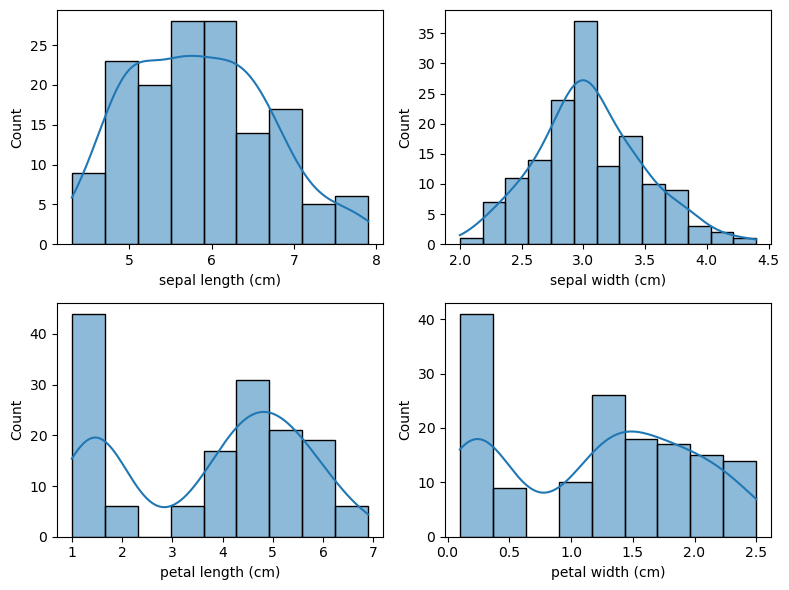

In [5]:
# Distribution of features
plt.figure(figsize=(8, 6))
for feature in data.columns[:-1]:
    i = data.columns.get_loc(feature)
    plt.subplot(2, 2, i+1)
    sns.histplot(data[feature], kde=True)
plt.tight_layout()
plt.show()

Interpretation of each histogram observed above:

Sepal Length (cm): This distribution is fairly bell-curved/normal, suggesting that the sepal length of the iris flowers in the dataset varies around an average of 5 to 6 cm.

Sepal Width (cm): The distribution of sepal width is also somewhat bell-curved/normal but appears slightly skewed to the right, indicating that most of the flowers have a sepal width around 3 cm, with some having a very small or very large width.

Petal Length (cm): The petal length distribution does not follow the bell-curve and shows 2 different peaks where measurements are concentrated implying that there are two different groups or species of iris flowers in the dataset with distinct petal lengths.

Petal Width (cm): Similarly, the petal width distribution also has 2 peaks, although the peaks are less distinct suggesting that there are also two different groups or species in the dataset with distinct petal widths.

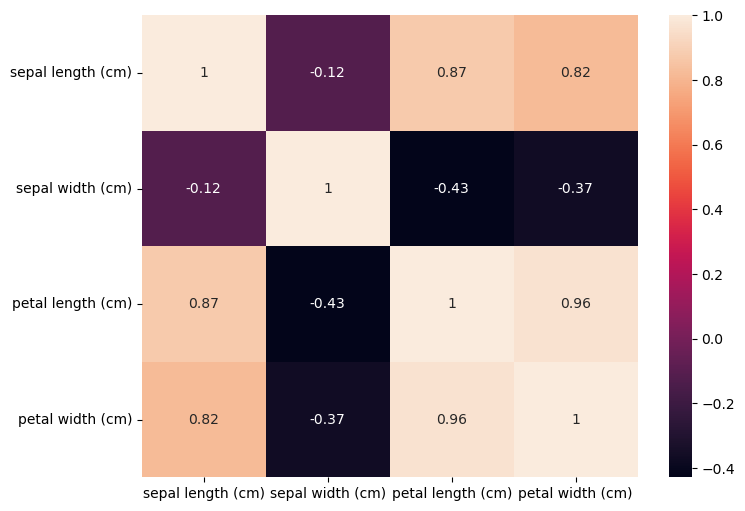

In [6]:
# Correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(data.iloc[:, :-1].corr(), annot=True)
plt.show()

As evident from the heatmap above, the dark purple blocks indicate negative correlation while brownish orange ones indicate positive correlation. Following are the observations:

There is a strong positive correlation between sepal length and both petal length of 0.87 and petal width of 0.82. However, sepal length shows a very weak negative correlation with sepal width of -0.12.

Sepal width exhibits a moderate negative correlation with both petal length of -0.43 and petal width of -0.36.

Petal length and petal width display a very strong positive correlation of 0.96.

/Users/aish/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


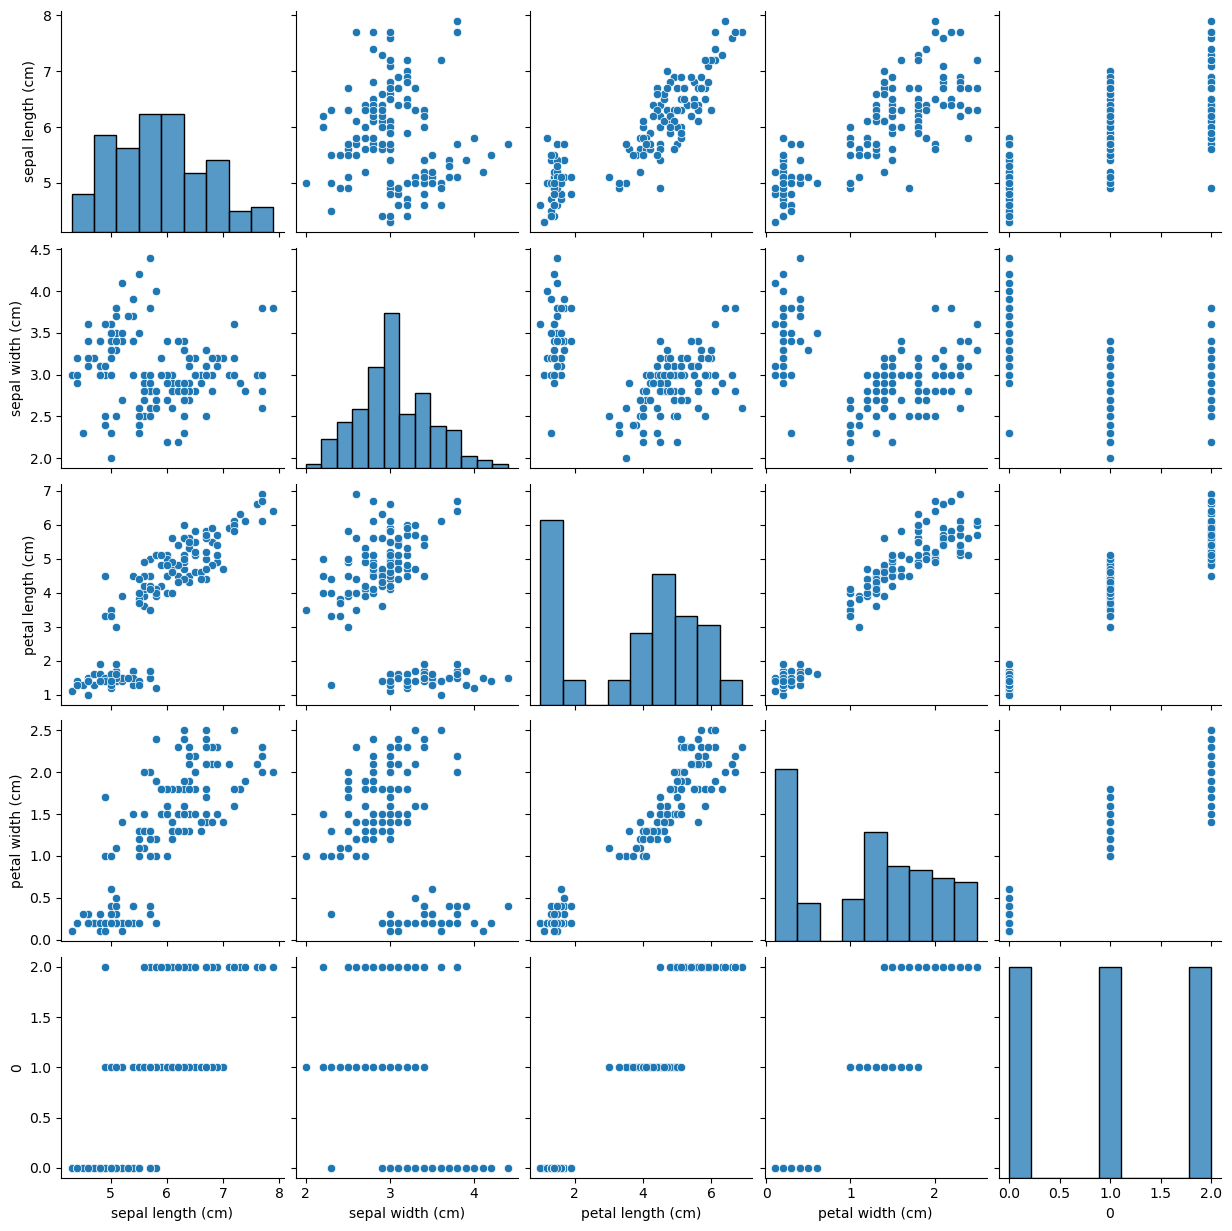

In [7]:
# Pair plot
sns.pairplot(data)
plt.show()

The pair plot indicates the relationships between sepal length, sepal width, petal length, and petal width in the iris dataset and the following can be concluded:

Sepal length and petal measurements are positively correlated.

Sepal width shows no clear correlation with petal sizes.

Petal length and width have a strong positive correlation.

The data suggest the presence of distinct clusters, likely representing different iris species.

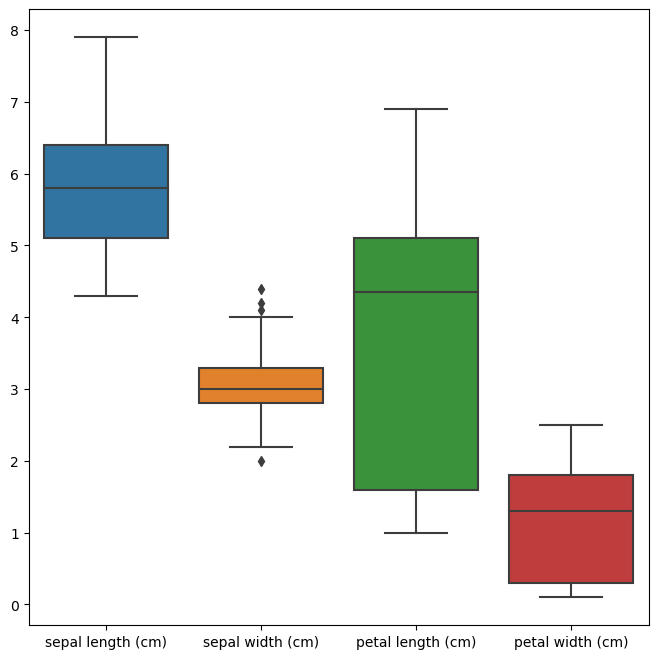

In [8]:
# Boxplot for outlier detection
plt.figure(figsize=(8, 8))
sns.boxplot(data=data.iloc[:, :-1])
plt.show()

This plot is helpful for understanding the central tendency, spread, and potential outliers within each measurement type for the Iris dataset. Therefore, the key observations are:

Sepal length has a median around 6 cm, with most data points falling between approximately 5.5 and 6.5 cm.

Sepal width has a smaller median near 3 cm and shows some outliers below the lower quartile.

Petal length has a higher median close to 5 cm, with a wider interquartile range indicating more variability.

Petal width has the lowest median, around 1.5 cm, with more uniform distribution but some outliers.

In [9]:
# Check for duplicates
duplicates = data.duplicated()
num_duplicates = duplicates.sum()

# Remove duplicates if any
if num_duplicates > 0:
    data = data.drop_duplicates()
    message = f"Found and removed {num_duplicates} duplicate rows."
else:
    message = "No duplicate rows found."

num_duplicates, message, data.shape

(1, 'Found and removed 1 duplicate rows.', (149, 5))

The above output indicates that there were initially 150 observations with 5 columns in the iris datset, out of which 1 was duplicate. Therefore, it was removed and the resulting dataset now comprises of 149 observations with 5 columns.

## Step 3: Decision Tree Implementation

In [10]:
def calculate_gini(y):   #calculates gini impurity of dataset
    classes = y.unique()
    impurity = 1.0
    for cls in classes:
        p = len(y[y == cls]) / len(y)
        impurity -= p**2
    return impurity

def best_split(X, y):    #Find the best feature and value to split on
    best_feature, best_value, best_gini, best_partitions = None, None, float("inf"), None
    for feature in X.columns:
        values = X[feature].unique()
        for value in values:
            left_mask = X[feature] < value
            right_mask = ~left_mask
            if not len(y[left_mask]) or not len(y[right_mask]):
                continue

            # Calculate the weighted Gini impurity for the split
            left_gini = calculate_gini(y[left_mask])
            right_gini = calculate_gini(y[right_mask])
            weight_left = len(y[left_mask]) / len(y)
            weight_right = len(y[right_mask]) / len(y)
            gini = left_gini * weight_left + right_gini * weight_right
            if gini < best_gini:
                best_gini = gini
                best_feature = feature
                best_value = value
                best_partitions = (left_mask, right_mask)
    return best_feature, best_value, best_partitions

class DecisionNode:   #decision tree node
    def __init__(self, feature=None, value=None, left=None, right=None, *, prediction=None):
        self.feature = feature #feature that the node splits on
        self.value = value     #threshold value for splitting
        self.left = left       #left child node obtained from the split
        self.right = right     #right child node obtained from the split
        self.prediction = prediction   #predicts class at leaf node otherwise None

def build_tree(X, y, depth=0, max_depth=2): #Recursively build the decision tree
    if depth == max_depth or len(y.unique()) == 1:
        return DecisionNode(prediction=y.mode()[0])
    feature, value, (left_mask, right_mask) = best_split(X, y)
    left_branch = build_tree(X[left_mask], y[left_mask], depth+1, max_depth)
    right_branch = build_tree(X[right_mask], y[right_mask], depth+1, max_depth)
    return DecisionNode(feature, value, left_branch, right_branch)

def predict(node, instance):  #Make a prediction for a single instance using the decision tree
    if node.prediction is not None:
        return node.prediction
    if instance[node.feature] < node.value:
        return predict(node.left, instance)
    else:
        return predict(node.right, instance)


Purpose of each function implemented above:

calculate_gini(y): Computes the Gini impurity for a set of class labels, which is a measure of the frequency at which any element of the set will be mislabeled if it was randomly labeled.

best_split(X, y): Determines the optimal feature and value to split the dataset into two groups to minimize Gini impurity, aiding in the decision-making process of the tree.

build_tree(X, y, depth=0, max_depth=2): Recursively builds a decision tree up to a specified depth by selecting the best splits based on Gini impurity.

predict(node, instance): Traverses the decision tree with an instance's features to arrive at a prediction based on the learned splits.

## Step 4: Tree Training

In [11]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train decision tree on the training set using the implemented algorithm
decision_tree = build_tree(X_train, y_train, max_depth=3)

## Step 5: Model Evaluation

In [12]:
# Make predictions on the test set
y_pred = X_test.apply(lambda instance: predict(decision_tree, instance), axis=1)

# Calculate accuracy
accuracy = (y_pred == y_test).mean()
print(f"Model accuracy: {accuracy}")

Model accuracy: 1.0


Considering the reported model accuracy of 1.0, such a high accuracy indicates that the model is performing perfectly on the test data, which is unlikely in most real-world scenarios and could suggest overfitting. We should also validate the model on an unseen dataset or use cross-validation to ensure the model's robustness. Additionally, reviewing the dataset's features and distribution would be important to ensure there's no data leakage or other issues that might have led to an overly optimistic performance metric.

#### Design Choices:

Gini Impurity: It was chosen as a measure to evaluate the quality of a split. It's a common choice due to its computational efficiency and suitability for binary classification problems.

Maximum Tree Depth: A max_depth of 3 is specified to prevent the tree from becoming too complex and overfitting the data. This is a form of regularization.

Train-Test Split: The dataset is divided into training and testing sets using a common 80-20 split. This ratio is widely used as it provides a sufficient amount of data for training while still reserving a meaningful portion for testing the model's performance.

Random State: Setting a random_state ensures that the results are reproducible. It's a good practice for debugging and comparison purposes.



#### Performance Reflection:

##### Strengths:

Interpretability: Decision trees are easy to understand and visualize. The decisions taken by the model can be easily explained.

Not a parametric Nature: They can fit the data with flexibility because they don't make any assumptions about the data's distribution.

Feature Selection: Decision trees are capable of performing feature selection by default, which is useful when there are a lot of features.

##### Limitations:

Overfitting: Without proper pruning or limiting the depth of the tree, decision trees can overfit the training data and perform poorly on unseen data.

Sensitivity to Variance: The training data of decision trees can vary greatly, resulting in distinct splits and tree structure.

Performance on Imbalanced Data: When dealing with imbalanced datasets, decision trees may exhibit bias towards the majority class.

Predictive Power: Decision trees frequently lack the same degree of predictive accuracy despite being easily understood and straightforward.